# Variable Length Motif Discovery for User Interaction Logs

Enhancing the publication of Hohenadl to reduce the dependency on window size

In [1]:
import sys
sys.path.append('../') # To import from parent dir
import os

import time

import pandas as pd
import numpy as np
import ast

from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder

import util.GrammarBasedUtil as grammar_util
import util.ui_stump as ui_stump

import util.valmod_uihe as valmod_util
from util.util import encoding_UiLog, read_data_for_processing
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

# LOCOmotif multi variate variable length motif discovery
# Source: https://github.com/ML-KULeuven/locomotif/tree/main
# Paper:  https://link.springer.com/article/10.1007/s10618-024-01032-z
import locomotif.locomotif as locomotif 
import util.locomotif_vis as visualize

c:\Users\tomho\anaconda3\envs\tsrdFall2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Configuration of Parameters for discovery

Set the following parameters to test our approach in different scenarions.
You can choos to set:

- **isSmartRPA** to **TRUE** if you want a smartRPA example log to be processed.
- **log_name_smartRPA** to **[LOGNAME]** if you want a specific log to be processed. If no log is entered the default is **LenLog_1_1_10_25_5_5000.csv**

- **isActionLogger** to **TRUE** if you want one of the Leno et al. logs to be processed.
- **leno_plus** to **TRUE** if you want the log first containing all student record routines before all reimbursement routines, if set to **FALSE** the student records and reimbursement routines alternate

- **isRealWorldTest** to **TRUE** if you want to test the approach on a small, real-world data set.

- **isHCI** to **TRUE** if you want a human-computer interaction log as a test sample. Please note: This log has only few attributes compared to a UI log and thus does not work properly. Furthermore it only contains routine executions and no inter-routine noise.

**PLEASE NOTE** The first **TRUE** value will be processed. If you want to have one of the later values to be processed, you have to set all previous values (expect leno_plus) to **FALSE**

#### Parameters

- **rule_density_threshold** is a threshold for Rule Density in Re-Pair. It increases the Grammar Rule Peak range by extending left and right until the rule count density drops below this threshold. E.g., if the rule-peak is at 10, the rules around this peak going to 8 or above will be included in the identified rule pattern.

- **stumpy_discovery_threshold** Threshold for STUMPY discovery as a true positiv when overlapping at least this much with a ground truth motif

- **app_switch_similarity_threshold** Threshold for considering a pattern drop in all discovered motifs as a pattern switch >> If less than x % share the same app, we consider this a switch

#### About the data

Depending on the selection before of the parameters of this notebook, the code prepares the data to make the notebook run smooth.
If a new log should be process-able, the preprocessing has to be added in the **uti.util.read_data_for_processing** function.

The following data is prepared for processing:
1. The context parameter levels according to the UI hierarchy reference model
   1. Each hierarchy level as an individual list
   2. hierarchy_list: A list of lists
   3. hierarchy_columns: A flattend (concatenated) list of the context parameters
2. The Ground Truth for Experiment comparison (Dataframe with columns: start_index, end_index, length)
3. CSV Read of the log(s)

#### Dataset Sources:

**SmartRPA**
Source: https://zenodo.org/records/6518291
Creation of noisy data as defined in: 04_validationLogCreation.ipynb

**Leno**
Source: https://figshare.com/articles/dataset/UI_logs/12543587/4
Extension with noise from Hohenadl: https://link.springer.com/chapter/10.1007/978-3-032-02936-2_20

**Real World Log**
The real world log is a recording of one of the authors over multiple distributed periods of research. The authors have cleaned the log by removing all identifiers of the author, any passwords or account names.

**HCI**
Source: https://springernature.figshare.com/collections/A_dataset_of_human-machine_interactions_for_a_smarter_UX/6612805

Setup of Data and reading of necessary files for SmartRPA validation



-------------------------------------------

**STEP 1**

Set the described parameters. After setting these according to your preference you can use **RUN ALL** in VS Code or similar methods in your IDE.

In [8]:
# Select the encoding method
# 1 - Word2Vec based encoding on context parameters
# 2 - Hierarchical encoding on context parameters
# 3 - Co-Occurrance Encoding
encoding_method = 1

# ---- Define if you want to process a sample Smart RPA Log ----
isSmartRPA2024 = False
# log_name_smartRPA = "LenLog_1_1_10_25_5_5000.csv" # 1 Routine Type, 10 Occurrances, 25 Routine Length, 5% of Log are Motifs
# log_name_smartRPA = "LenLog_1_10_1_10_5_1_5000.csv" # 1 Routine Type, 10 Intra-Routine Noise, 10 Occurances, 5 Routine Length, 1% of Log are Motifs
log_name_smartRPA = "LenLog_1_20_1_15_15_1_22500.csv" # 1 Routine Type, 20 Intra-Routine Noise, 15 Occurances, 15 Routine Length, 1% of Log are Motifs
log_name_smartRPA = "LenLog_1_20_1_15_25_1_37500.csv" # 1 Routine Type, 20 Intra-Routine Noise, 15 Occurances, 25 Routine Length, 1% of Log are Motifs
log_name_smartRPA = "LenLog_1_20_1_10_5_1_5000.csv"

# ---- Smart RPA New 2025 Validation Data for Var Length Motif Discovery ----
isSmartRPA2025 = True
log_name_smartRPA = "log_motifs5_occurances10_length20_percentage25_shuffle0.2.csv"

# ---- Leno Sequential Log ----
isActionLogger = False
leno_plus = False 

# ---- Real World Test Recording Author ----
isRealWorldTest = True

# ---- HCI Based Log ----

isHCI = False

# ---- Generic Parameters that were tested in other publications ----


rule_density_threshold = 0.8 # Threshold for Rule Density in Re-Pair >> Grammar Rule Peak is extended left and right until the rule count density drops below this threshold
stumpy_discovery_threshold = 0.5 # Threshold for STUMPY discovery as a true positiv when overlapping at least this much with a ground truth motif
app_switch_similarity_threshold = 0.75 # Threshold for considering a pattern drop in all discovered motifs as a pattern switch >> If less than x % share the same app, we consider this a switch

**STEP 2** 

Read the data and gather the parameters for processing.

In [9]:
data_for_processing = read_data_for_processing(isSmartRPA2024=isSmartRPA2024,
                                               isSmartRPA2025=isSmartRPA2025,
                                                    isRealWorldTest=isRealWorldTest,
                                                    isActionLogger=isActionLogger,
                                                    leno_plus=leno_plus,
                                                    isHCI=isHCI,
                                                    log_name_smartRPA=log_name_smartRPA,
                                                    encoding_method=encoding_method)

# Unpack the returned dictionary
hierarchy_list = data_for_processing["hierarchy_list"]
hierarchy_columns = data_for_processing["hierarchy_columns"]
hierarchy_columns_app_switch = data_for_processing["hierarchy_columns_app_switch"]
file = data_for_processing["file"]
log = data_for_processing["log"]
ground_truth = data_for_processing["ground_truth"]
ui_log_encoded = data_for_processing["ui_log_encoded"]
ground_truth_start_list = data_for_processing["ground_truth_start_list"]
column_identifier = data_for_processing["column_identifier"]

# Apply the Grammar Based Rule Discovery
encoding_df, symbols, two_gram_df = grammar_util.re_pair(log)
last_entry = len(encoding_df["new_symbol"])-1
last_encoding = encoding_df["new_symbol"].iloc[last_entry]
print("\n Last Encoded Entry: ",last_encoding)
decoded_symbol = grammar_util.re_pair_decode_symbol(last_encoding, encoding_df, printing=True)

Processing file: log_motifs5_occurances10_length20_percentage25_shuffle0.2.csv with 4000 events.
Using Word2Vec based encoding for UI Log
140  unique pairs found so far. Rule-Level:  1
224  unique pairs found so far. Rule-Level:  2
261  unique pairs found so far. Rule-Level:  3
274  unique pairs found so far. Rule-Level:  4
279  unique pairs found so far. Rule-Level:  5

 Last Encoded Entry:  js
js → (jc, ij)
  jc → (fp, il)
    fp → (bl, bn)
      bl → (RI, YY)
        RI → [base symbol]
        YY → [base symbol]
      bn → (AGF, TD)
        AGF → [base symbol]
        TD → [base symbol]
    il → (fr, fv)
      fr → (bp, br)
        bp → (N, IM)
          N → [base symbol]
          IM → [base symbol]
        br → (CB, AHE)
          CB → [base symbol]
          AHE → [base symbol]
      fv → (bt, bv)
        bt → (P, SD)
          P → [base symbol]
          SD → [base symbol]
        bv → (RL, ZO)
          RL → [base symbol]
          ZO → [base symbol]
  ij → (gc, gh)
    gc → (b

**STEP 3**

Visualize the Rule-Density Curve based on Ground Truth data.

In [10]:
# ---- Initialize the count column ----
start_time = time.time()
log = grammar_util.generate_density_count(encoding_df, log)
end_time = time.time()

Exec. Time with loops: 3.891 seconds
Start Index of the first ground truth motif: 71


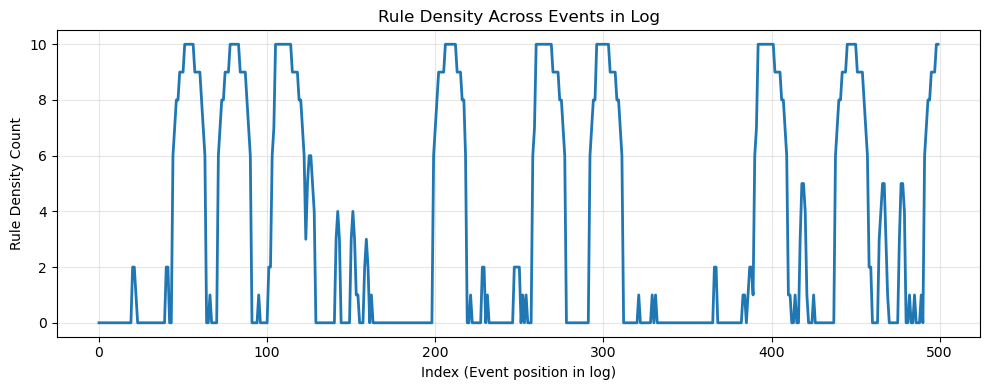

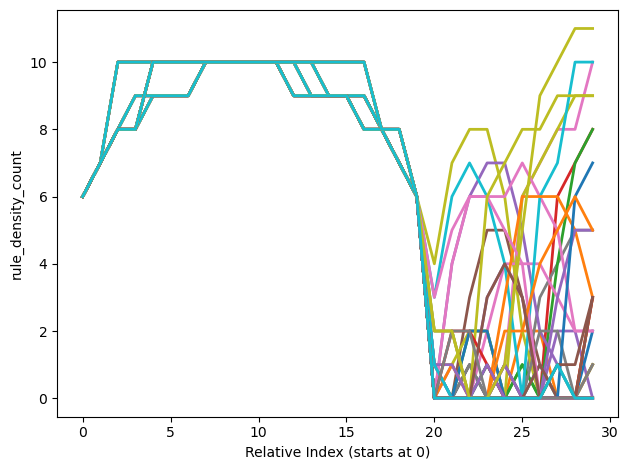

Maximum rule density count: 12
Longest identified motif length: 13



In [11]:
print(f"Exec. Time with loops: {end_time - start_time:.3f} seconds")
motiv = int(ground_truth.iloc[0]["start_index"])
print(f"Start Index of the first ground truth motif: {motiv}")
grammar_util.plot_density_curve(log, range_low=0, range_high=min(500, len(log)))

colors = plt.cm.tab10.colors
length = ground_truth["length"].max()
for i, start in enumerate(ground_truth["start_index"]):
    end = start+length+10
    y = log.iloc[start:end]["rule_density_count"].to_numpy()
    x = range(len(y))  # all start at 0
    plt.plot(x, y, color=colors[i % len(colors)], linewidth=2, label=f"Range {start}-{end}")

plt.xlabel("Relative Index (starts at 0)")
plt.ylabel("rule_density_count")
plt.tight_layout()
plt.show()

max_rule_density_count, max_groups = grammar_util.find_max_density_groups(log,relative_threshold=rule_density_threshold)
max_groups_df = pd.DataFrame(columns=["group","processed"])
max_groups_df["group"] = max_groups

# Add start and end indices to the dataframe
max_groups_df["start_index"] = -1
max_groups_df["end_index"] = -1
for i, grammer_motif in max_groups_df.iterrows():
    max_groups_df.loc[i, "start_index"] = min(grammer_motif['group'])
    max_groups_df.loc[i, "end_index"] = max(grammer_motif['group'])

start_indices = max_groups_df["start_index"].tolist()
end_indices = max_groups_df["end_index"].tolist()

print(f"Maximum rule density count: {max_rule_density_count}")
max_length = -1
min_length = len(log)
for motif in max_groups:
    if len(motif) > max_length:
        max_length = len(motif)
    if len(motif) > 0 and len(motif) < min_length:
        min_length = len(motif)
print(f"Longest identified motif length: {max_length}\n")

**STEP 4**

Calculate the discovery scores for the rule-density counts based on the ground truth.

intersection_ratio: 0.877
intersection_abs: 7.719
undercount_ratio: 0.560
undercount_abs: 11.200
over_detection_ratio: 0.123
over_detection_abs: 0.456

Precision: 0.877, Recall: 1.000, F1: 0.935


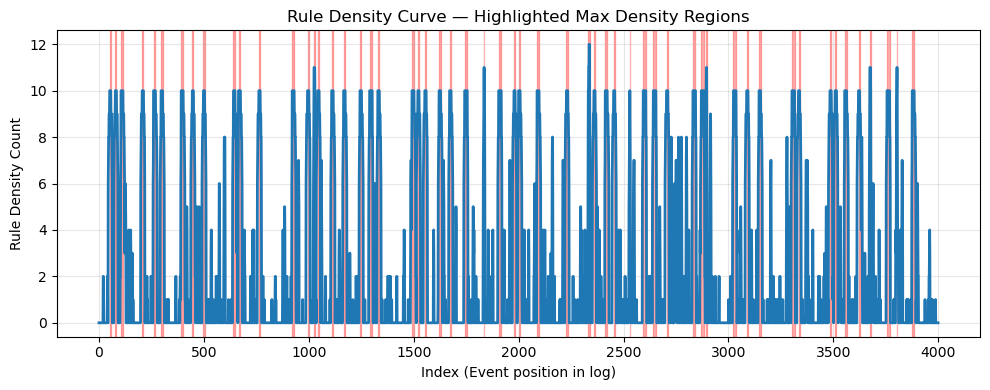

In [12]:
overlaps = grammar_util.find_overlaps(max_groups, ground_truth)

stats = grammar_util.motif_overlap_metrics(max_groups, ground_truth)
for key, value in stats.items():
    print(f"{key}: {value:.3f}")

# Version with over counting as two overlaps could span a single ground truth
# Especially occurring with longer motifs
tp = len(overlaps)                      # true positives = overlapping ranges
fp = len(max_groups) - tp               # predicted but not in ground truth
fn = len(ground_truth) - tp             # missed ground truth ranges

matched, tp, fp, fn, gt1 = grammar_util.match_motifs_to_gt(max_groups, ground_truth)

precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


# ---- Plotting the results ----
plt.figure(figsize=(10, 4))
plt.plot(log.index, log["rule_density_count"], linewidth=2)
for g in max_groups:
    plt.axvspan(g[0], g[-1], color="red", alpha=0.3)
plt.title("Rule Density Curve — Highlighted Max Density Regions")
plt.xlabel("Index (Event position in log)")
plt.ylabel("Rule Density Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**STEP 5**

Identify app switches and filter the original log to rule-density based motif candidates

**STEP 6** 

Execute variable length motif discovery on the filtered log using LoCoMotif.

Total Included Range Length: 1524 of 4000
Percentage of Log Included: 38.10%
Using Word2Vec based encoding for UI Log
Rule Density Curve before Filtering:


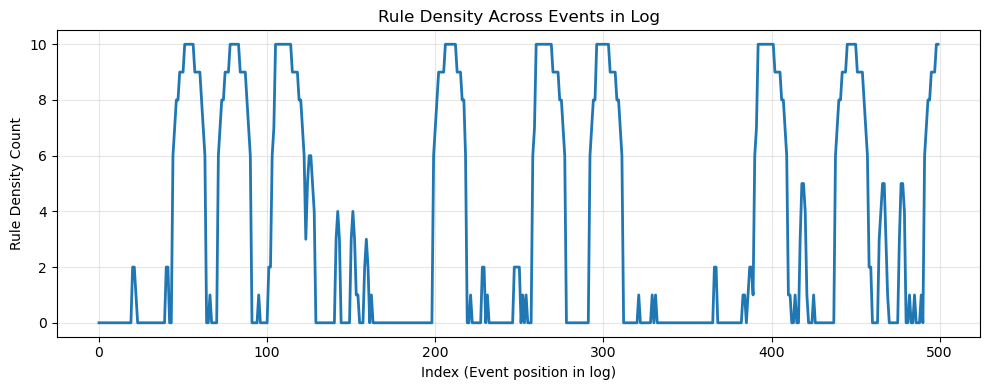

Rule Density Curve after Filtering:


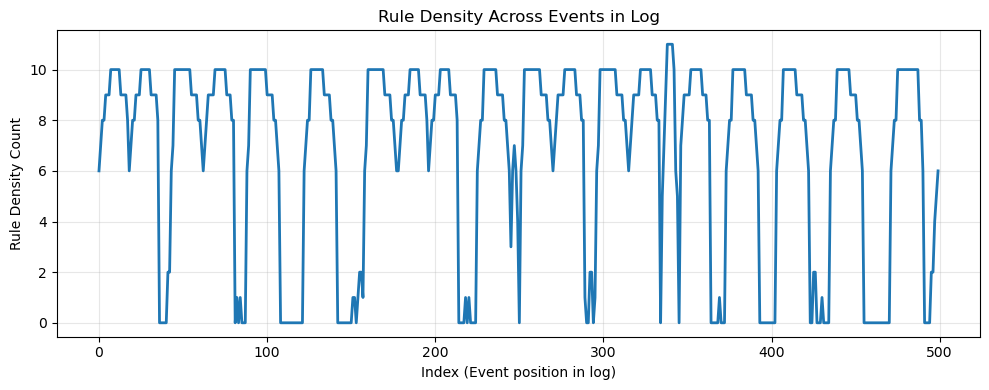

c:\Users\tomho\anaconda3\envs\tsrdFall2025\Lib\site-packages\locomotif\locomotif.py:48: UserWarning: It is highly recommended to z-normalize the input time series before applying LoCoMotif to it.
  warnings.warn("It is highly recommended to z-normalize the input time series before applying LoCoMotif to it.")


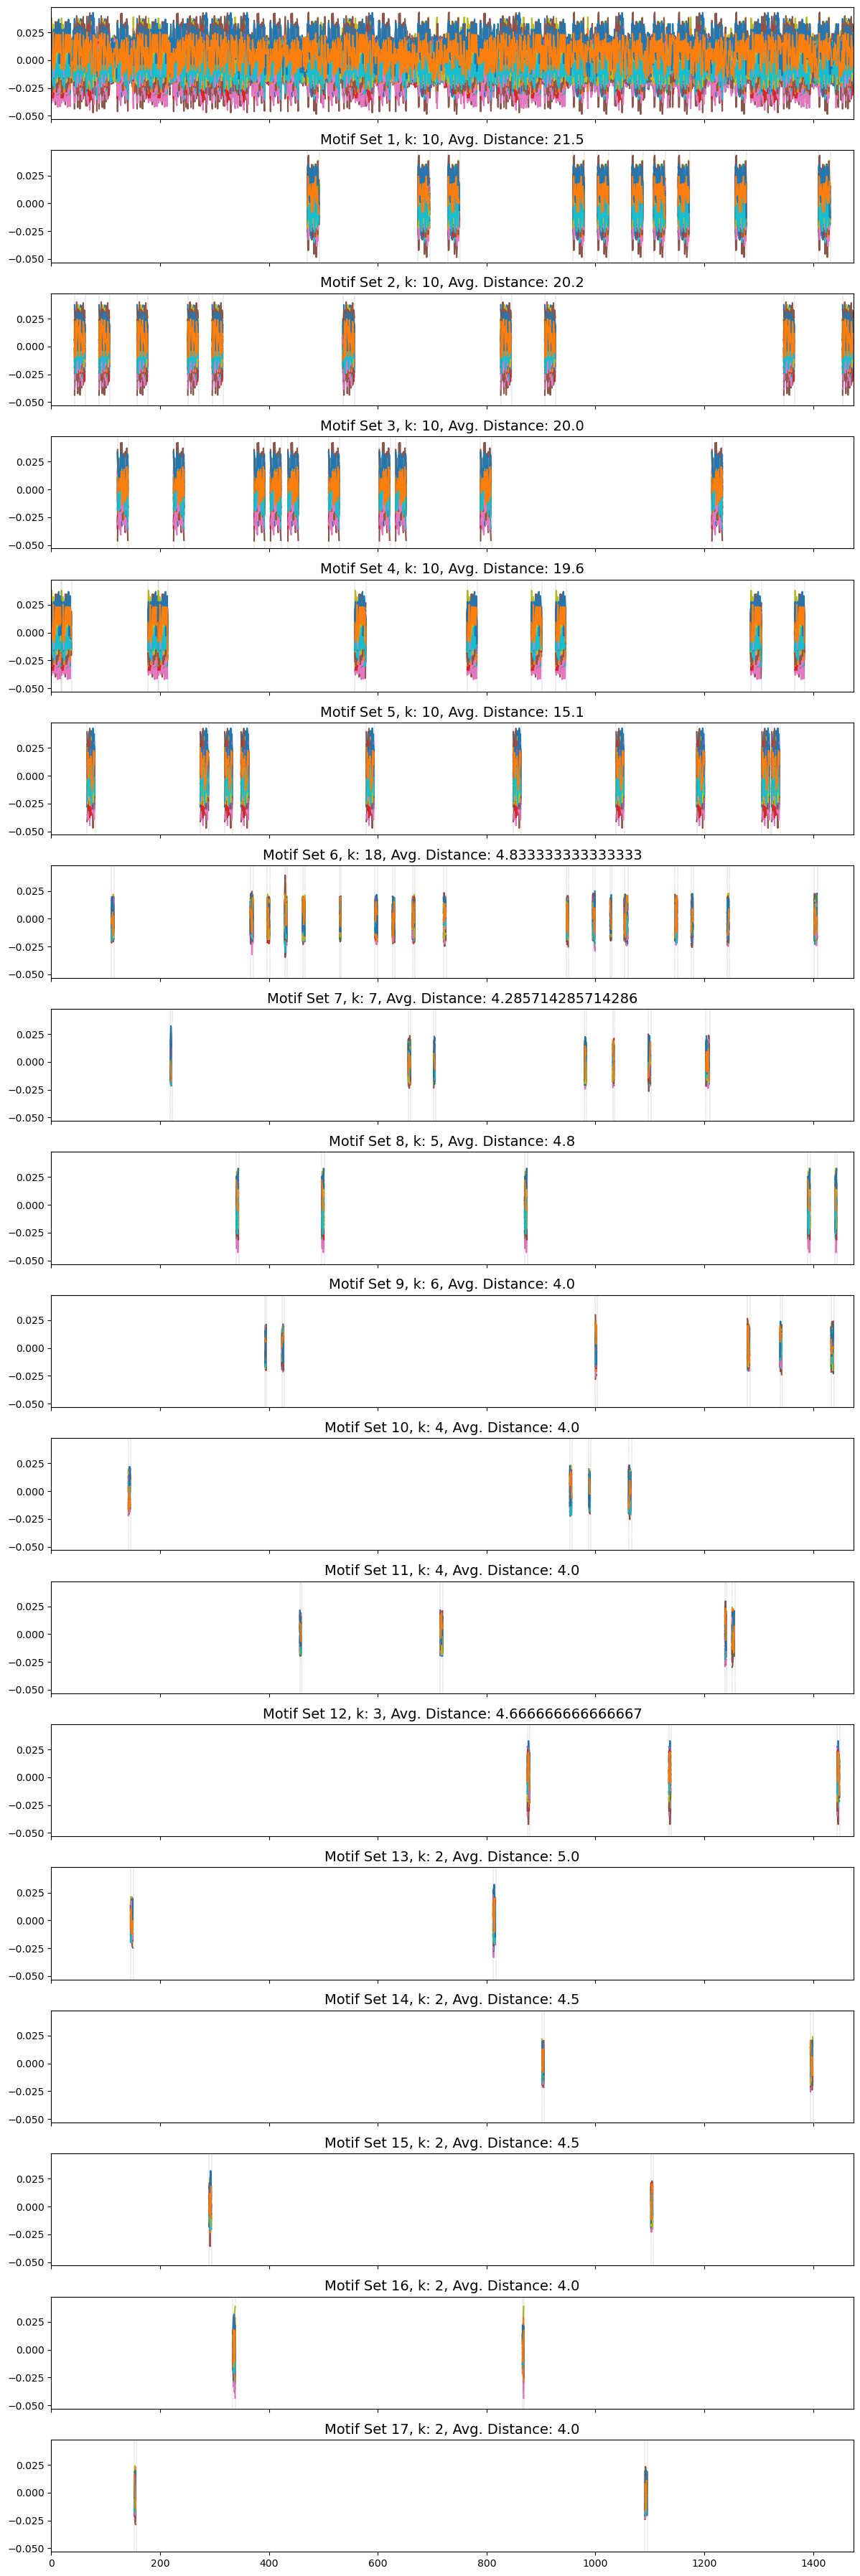

In [13]:
# Extend until the app changes for the specific pattern and add as "lower_app_switch" and "upper_app_switch"
max_groups_df = grammar_util.app_switch_miner(log, max_groups_df, hierarchy_columns_app_switch)

lower_app_switches = max_groups_df["lower_app_switch"].tolist()
upper_app_switches = max_groups_df["upper_app_switch"].tolist()

# Mine the similar paths up and down until an app switch across discovered patterns is found
result_df = grammar_util.similar_path_up_down(
    df=log,
    max_groups_df=max_groups_df,
    start_indices=lower_app_switches,
    end_indices=upper_app_switches,
    cols=hierarchy_columns_app_switch,
    min_pairs=len(lower_app_switches)*app_switch_similarity_threshold, # At least 75% of the patterns should be similar in path
)

# build list of all valid index ranges
valid_indices = []

# Include additional safety margin until pattern switch
range_sum = 0
for _, row in result_df.iterrows():
    safety_margin = int(row['upper_pattern_switch']) - int(row['lower_pattern_switch']) 
    valid_indices.extend(range(max(0, int(row['lower_pattern_switch'])-safety_margin),
                            min(int(row['upper_pattern_switch'])+safety_margin, len(log)-1)))
    range_distance =  min(int(row['upper_pattern_switch'])+safety_margin, len(log)-1) - max(0, int(row['lower_pattern_switch'])-safety_margin)
    range_sum += range_distance
print(f"Total Included Range Length: {range_sum} of {len(log)}")
print(f"Percentage of Log Included: {range_sum/len(log)*100:.2f}%")

# filter log to include only those indices
filtered_log = log.loc[log.index.intersection(valid_indices)].copy()

# optionally, keep the original index as a column for traceability
filtered_log['original_index'] = filtered_log.index

# Encode the filtered log
if encoding_method == 1:
    print("Using Word2Vec based encoding for UI Log")
    filtered_log_encoded = valmod_util.encode_word2vec(filtered_log, orderedColumnsList=hierarchy_columns, vector_size=len(hierarchy_columns)*2)
    column_identifier = 'w2v_'
elif encoding_method == 2:
    print("Using Hierarchical based encoding for UI Log")
    filtered_log_encoded = encoding_UiLog(filtered_log,orderedColumnsList=hierarchy_columns,encoding=1)
    column_identifier = 'tuple:id'
elif encoding_method == 3:
    print("Using Co-Occurrance based encoding for UI Log")
    filtered_log_encoded = encoding_UiLog(filtered_log,orderedColumnsList=hierarchy_columns,encoding=2)
    column_identifier = 'tuple:id'
else:
    raise ValueError("Invalid encoding method selected. Choose 1, 2, or 3.")


df_filtered_for_plotting = filtered_log.reset_index(drop=True)
print("Rule Density Curve before Filtering:")
grammar_util.plot_density_curve(log, range_low=0, range_high=min(500, len(log)))
print("Rule Density Curve after Filtering:")
grammar_util.plot_density_curve(df_filtered_for_plotting, range_low=0, range_high=min(500, len(df_filtered_for_plotting)))

# Reduce the data to an ordered time series for locomotif
filtered_columns_reduced_log = filtered_log_encoded.filter(like=column_identifier)

# Optional: Normalization
#ts = (filtered_columns - np.mean(filtered_columns, axis=None)) / np.std(filtered_columns, axis=None)

# Variable Length Motif Discovery
motif_sets = locomotif.apply_locomotif(filtered_columns_reduced_log, l_min=5, l_max=65, rho=0.9)

# Plotting with adjusted locomotif visualization (utils)
fig, ax = visualize.plot_motif_sets(filtered_columns_reduced_log.values, motif_sets, legend=False)
plt.show()

#### Execution of LOCOMOTIF on complete log

The following code uses the same data as before, but instead of reducing the log down to high-rule based candidates it executed LoCoMotif on the complete dataset.

The parameters selected on the top of the Notebook apply.

c:\Users\tomho\anaconda3\envs\tsrdFall2025\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


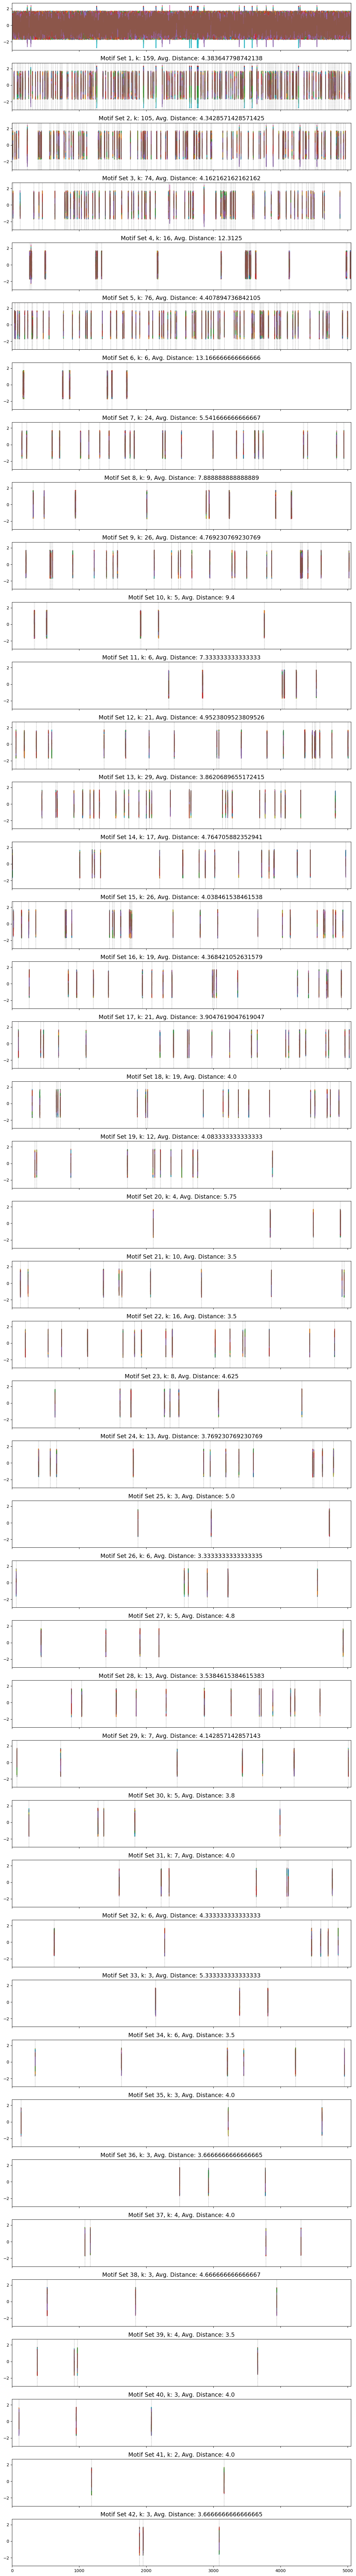

In [63]:
# Reduce the data to an ordered time series for locomotif
filtered_columns = ui_log_encoded.filter(like=column_identifier)

# Optional: Normalization
ts = (filtered_columns - np.mean(filtered_columns, axis=None)) / np.std(filtered_columns, axis=None)

# Variable Length Motif Discovery
motif_sets = locomotif.apply_locomotif(ts, l_min=5, l_max=65, rho=0.9)

# Plotting with adjusted locomotif visualization (utils)
fig, ax = visualize.plot_motif_sets(ts.values, motif_sets, legend=False)
plt.show()

In [64]:
# build motif_df from valmod
motif_intervals = []
for motif, instances in motif_sets:
    for s, e in instances:
        motif_intervals.append((s, e))
motif_df = pd.DataFrame(motif_intervals, columns=["motif_start", "motif_end"])

def interval_overlap(a_start, a_end, b_start, b_end, tol=0):
    return max(0, min(a_end + tol, b_end) - max(a_start, b_start - tol))

tol = 0

# 1) which motifs hit at least one GT?
motif_hits = []
for midx, m in motif_df.iterrows():
    mstart, mend = m["motif_start"], m["motif_end"]
    hit = False
    for _, gt in ground_truth.iterrows():
        if interval_overlap(mstart, mend, gt["start_index"], gt["end_index"], tol) > 0:
            hit = True
            break
    motif_hits.append(hit)

n_motifs = len(motif_df)
n_motifs_hit = sum(motif_hits)
precision = n_motifs_hit / n_motifs if n_motifs else 0.0

# 2) which GT cases are hit by at least one motif?
case_hits = []
for _, gt in ground_truth.iterrows():
    gstart, gend = gt["start_index"], gt["end_index"]
    hit = False
    for _, m in motif_df.iterrows():
        if interval_overlap(gstart, gend, m["motif_start"], m["motif_end"], tol) > 0:
            hit = True
            break
    case_hits.append(hit)

n_cases = len(ground_truth)
n_cases_hit = sum(case_hits)
recall = n_cases_hit / n_cases if n_cases else 0.0

f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

print(f"precision={precision:.3f}, recall={recall:.3f}, f1={f1:.3f}")

precision=0.014, recall=1.000, f1=0.027


### Execution of Word2Vec + MSTUMP

For comparison methods a word2vec based multi-dimensional motif discovery can be executed here.
This is based on the research paper by Hohenadl: https://link.springer.com/chapter/10.1007/978-3-032-02936-2_20

_________________________

**STEP 1**

Set Parameters

In [65]:
size = 5  # For Word2Vec-Stump based Discovery
motifs_to_discover = 60

**STEP 2**

Execute MSTUMP (Multi-Dimensional Motif Discovery) using the STUMPY implementation by Law: STUMPY: A Powerful and Scalable Python Library for Time Series Data Mining / https://joss.theoj.org/papers/10.21105/joss.01504

Discovered Motif Indexes: [69, 128, 785, 828, 1022, 1073, 1260, 1593, 1620, 1675, 1722, 1957, 2143, 2193, 2395, 2404, 2609, 2644, 2669, 2742, 2758, 2771, 3093, 3159, 3186, 3266, 3460, 3576, 3591, 3789, 4103, 4199, 4235, 4267, 4457, 4489, 4509, 4710, 4716]
Ground Truth:   caseid  start_index  length  end_index  discovery_count
1       1          225       5        230                1
5       5          278       5        283                1
7       7         2234       5       2239                1
3       3         2858       5       2863                1
6       6         3383       5       3388                0
9       9         3647       5       3652                1
2       2         3785       5       3790                0
4       4         3887       5       3892                0
0       0         4288       5       4293                1
8       8         4540       5       4545                0
No discovered motifs with sufficient coverage found.
Precision: 0.0
Recall: 0.0
F1

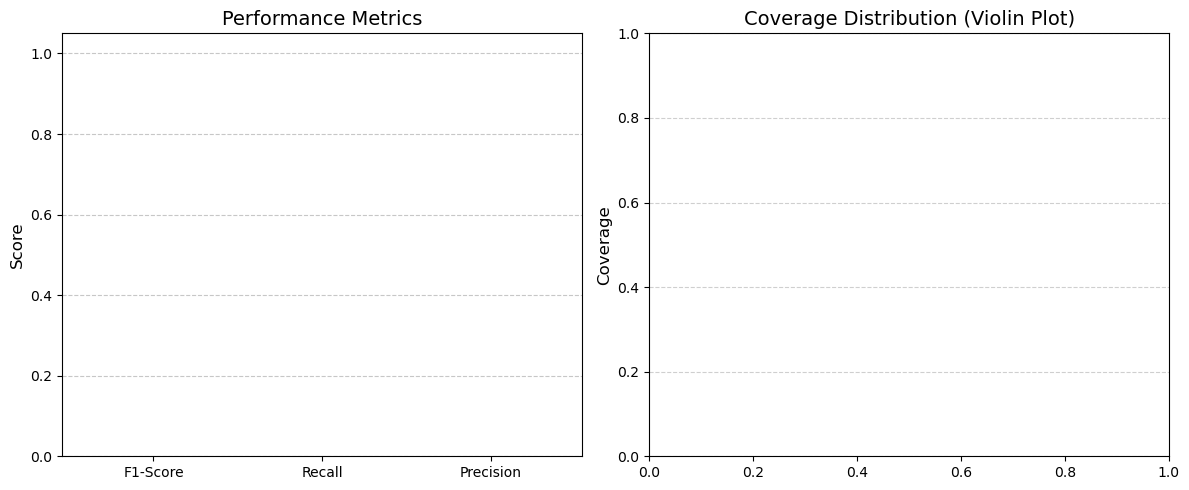

In [ ]:
# '# ground_truth => Dataframe with columns: caseid, start_index, length, end_index
# # log => Dataframe with all events symbolized according to hierarchy_columns
# # hierarchy_columns => List of Lists with all hierarchy levels used for symbolization
# # hierarchy_list => Flattened list of hierarchy_columns

motif_distances, motif_indices, motif_subspaces, motif_mdls = valmod_util.mine_w2v(ui_log_encoded,column_identifier,size,motifs_to_discover)
print(f"Discovered Motif Indexes: {sorted(motif_indices[0])}")

print(f"Ground Truth:{ground_truth}")

# ---- Measuring Method: Half the Window Size ----
# insert_spots, motif_spots, overlapDF = valmod_util.compare_sets(set(groundTruth), set(motif_indices[0]), (size/2))

# >> Could be updated and use the ground truth dfs instean of the list
original_inserts_indexes, discovered_motif_spots, overlapDF = valmod_util.compute_discovery_coverage(ground_truth_start_list, set(motif_indices[0]), size, threshold=stumpy_discovery_threshold)
mean_coverage = 0

if 'coverage' in overlapDF.columns:
    mean_coverage = overlapDF.loc[:, "coverage"].mean()

ground_truth_sum = len(ground_truth)
true_positives = len(original_inserts_indexes)
false_positives = motifs_to_discover - true_positives  # Incorrectly identified motifs
false_negatives = ground_truth_sum - true_positives  # Relevant motifs not identified

# Precision
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
print(f"Precision: {precision}")

# Recall
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
print(f"Recall: {recall}")

# F1-Score
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-Score: {f1_score}")

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Bar Chart ---
metrics = ['F1-Score', 'Recall', 'Precision', 'Coverage']
values = [f1_score, recall, precision, mean_coverage]
axes[0].bar(metrics, values, color='skyblue')
axes[0].set_ylim(0, 1.05)  # Slightly higher to leave space for label

axes[0].set_title('Performance Metrics', fontsize=14)
axes[0].set_ylabel('Score', fontsize=12)

for i, v in enumerate(values):
    if v > 0.5:
        offset = -0.05 if v > 0.98 else 0.02  # Push label down if bar is too high
        axes[0].text(i, v + offset, f"{v:.2f}", ha='center', va='top' if offset < 0 else 'bottom', fontsize=10)

axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# --- Violin Plot with Points for IoU ---
sns.violinplot(y=overlapDF["coverage"], ax=axes[1], inner=None, color='lightblue')
sns.stripplot(y=overlapDF["coverage"], ax=axes[1], color='black', size=3, jitter=0.2)
axes[1].set_title("Coverage Distribution (Violin Plot)", fontsize=14)
axes[1].set_ylabel("Coverage", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()